In [1]:
!pip install panns-inference transformers pretty_midi torch torchvision pandas scikit-learn matplotlib seaborn tqdm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 51.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.5 MB

In [2]:
import os
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import librosa
import pretty_midi
import torchvision.models as models
import torchvision.transforms as T

from transformers import BertTokenizer, BertModel
from panns_inference import AudioTagging

from tqdm.auto import tqdm

# Setup
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Reproducibility
RANDOM_SEED = 42
def seed_everything(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(RANDOM_SEED)

2025-12-15 13:38:22.797854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765805902.957483      97 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765805903.005718      97 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Device: cuda


--2025-12-15 13:38:39--  http://storage.googleapis.com/us_audioset/youtube_corpus/v1/csv/class_labels_indices.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.207, 74.125.20.207, 173.194.202.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14675 (14K) [application/octet-stream]
Saving to: ‘/root/panns_data/class_labels_indices.csv’

     0K .......... ....                                       100%  181M=0s

2025-12-15 13:38:39 (181 MB/s) - ‘/root/panns_data/class_labels_indices.csv’ saved [14675/14675]



In [3]:
# ============= DATA PATH =============
DATA_ROOT   = "/kaggle/input/multimodal-mirex-emotion-dataset/dataset"
AUDIO_DIR   = f"{DATA_ROOT}/Audio"
LYRICS_DIR  = f"{DATA_ROOT}/Lyrics"
MIDI_DIR    = f"{DATA_ROOT}/MIDIs"

CATEGORIES_TXT = f"{DATA_ROOT}/categories.txt"
CLUSTERS_TXT   = f"{DATA_ROOT}/clusters.txt"

# 1. Load File IDs based on Audio (Anchor)
audio_files = sorted(glob.glob(os.path.join(AUDIO_DIR, "*.mp3")))
file_ids = [os.path.splitext(os.path.basename(x))[0] for x in audio_files]

# 2. Load Labels
with open(CATEGORIES_TXT, "r", encoding="utf-8") as f:
    categories = [x.strip() for x in f.readlines()]
    categories = ["Aggressive" if c.lower() == "agressive" else c for c in categories]

with open(CLUSTERS_TXT, "r", encoding="utf-8") as f:
    clusters = [x.strip() for x in f.readlines()]

# 3. Create DataFrame
meta_df = pd.DataFrame({
    "file_id": file_ids,
    "category": categories,
    "cluster_name": clusters
})

def parse_cluster_id(x):
    if str(x).lower().startswith("cluster"):
        return int(str(x).replace("Cluster", "").strip()) - 1
    return 0

meta_df["target"] = meta_df["cluster_name"].apply(parse_cluster_id)

# 4. Generate Paths
meta_df["audio_path"]  = meta_df["file_id"].apply(lambda x: os.path.join(AUDIO_DIR,  f"{x}.mp3"))
meta_df["lyrics_path"] = meta_df["file_id"].apply(lambda x: os.path.join(LYRICS_DIR, f"{x}.txt"))
meta_df["midi_path"]   = meta_df["file_id"].apply(lambda x: os.path.join(MIDI_DIR,   f"{x}.mid"))

# --- CEK KETERSEDIAAN FILE (Data Checking) ---
meta_df["has_audio"]  = meta_df["audio_path"].apply(os.path.exists)
meta_df["has_lyrics"] = meta_df["lyrics_path"].apply(os.path.exists)
meta_df["has_midi"]   = meta_df["midi_path"].apply(os.path.exists)

print(f"Total Dataset Samples (Based on Audio): {len(meta_df)}")
print("-" * 30)
print(f"Audio Files Present : {meta_df['has_audio'].sum()}")
print(f"Lyrics Files Present: {meta_df['has_lyrics'].sum()}")
print(f"MIDI Files Present  : {meta_df['has_midi'].sum()}")
print("-" * 30)
print(f"Complete Data (Audio+Lyrics+MIDI): {len(meta_df[meta_df['has_audio'] & meta_df['has_lyrics'] & meta_df['has_midi']])}")
print("Strategy: Missing modalities will be zero-padded (Zero Imputation).")

Total Dataset Samples (Based on Audio): 903
------------------------------
Audio Files Present : 903
Lyrics Files Present: 764
MIDI Files Present  : 196
------------------------------
Complete Data (Audio+Lyrics+MIDI): 193
Strategy: Missing modalities will be zero-padded (Zero Imputation).


In [4]:
# ============= HYPERPARAMETERS =============
# Feature Config
SR = 32000
MAX_LEN_LYR = 128
WINDOW_SEC = 30

# Training Config
TEST_SPLIT = 0.10   # 10% Test (Hold-out)
VAL_SPLIT  = 0.10   # 10% dari sisa 90% digunakan untuk Validasi
EPOCHS = 30 
BATCH_SIZE = 32
LR = 1e-4
WEIGHT_DECAY = 1e-2
DROPOUT = 0.3
AUG_NOISE_STD = 0.05 

print(f"Hyperparameters set. Test Split: {TEST_SPLIT*100}%")

Hyperparameters set. Test Split: 10.0%


In [5]:
# --- 1. AUDIO (PANNs) ---
at_model = AudioTagging(checkpoint_path=None, device='cuda' if torch.cuda.is_available() else 'cpu') 

def get_audio_embedding(path):
    if not os.path.exists(path): return np.zeros(2048, dtype=np.float32)
    (audio, _) = librosa.core.load(path, sr=SR, mono=True)
    audio = audio[None, :]
    with torch.no_grad():
        _, embedding = at_model.inference(audio)
    return embedding.squeeze(0)

# --- 2. LYRICS (BERT) ---
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device).eval()

def get_lyrics_embedding(path):
    if not os.path.exists(path): return np.zeros(768, dtype=np.float32)
    try:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            text = f.read().strip()
        if not text: return np.zeros(768, dtype=np.float32)
    except: return np.zeros(768, dtype=np.float32)

    enc = tokenizer(text, max_length=MAX_LEN_LYR, truncation=True, 
                    padding="max_length", return_tensors="pt").to(device)
    with torch.no_grad():
        out = bert_model(**enc).last_hidden_state
        mask = enc["attention_mask"].unsqueeze(-1)
        pooled = (out * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
    return pooled.squeeze(0).cpu().numpy()

# --- 3. MIDI (ResNet) ---
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet.fc = nn.Identity()
resnet = resnet.to(device).eval()

midi_transform = T.Compose([
    T.ToTensor(), T.Resize((224, 224), antialias=True),
    T.Lambda(lambda x: x.repeat(3, 1, 1)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def get_midi_embedding(path):
    if not os.path.exists(path): return np.zeros(512, dtype=np.float32)
    try:
        pm = pretty_midi.PrettyMIDI(path)
        end_time = min(WINDOW_SEC, pm.get_end_time())
        if end_time <= 0: return np.zeros(512, dtype=np.float32)
        roll = pm.get_piano_roll(fs=10, times=np.linspace(0, end_time, int(10*end_time)+1))
        roll = (roll > 0).astype(np.float32)
        img_tensor = midi_transform(roll).unsqueeze(0).to(device)
        with torch.no_grad():
            emb = resnet(img_tensor)
        return emb.squeeze(0).cpu().numpy()
    except: return np.zeros(512, dtype=np.float32)

print("Models ready.")

Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth


--2025-12-15 13:38:43--  https://zenodo.org/record/3987831/files/Cnn14_mAP%3D0.431.pth?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.75, 188.185.43.153, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.75|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3987831/files/Cnn14_mAP=0.431.pth [following]
--2025-12-15 13:38:44--  https://zenodo.org/records/3987831/files/Cnn14_mAP=0.431.pth
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 327428481 (312M) [application/octet-stream]
Saving to: ‘/root/panns_data/Cnn14_mAP=0.431.pth’

     0K .......... .......... .......... .......... ..........  0%  158K 33m45s
    50K .......... .......... .......... .......... ..........  0%  320K 25m12s
   100K .......... .......... .......... .......... ..........  0%  318K 22m23s
   150K .......... .......... .......... .......... ..........  0%  322K 20m55s
   200K .....

GPU number: 1


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


Models ready.


In [6]:
X_audio, X_lyrics, X_midi = [], [], []
y_labels = meta_df["target"].values
ids = meta_df.index.values

print("Extracting features...")

for idx, row in tqdm(meta_df.iterrows(), total=len(meta_df)):
    X_audio.append(get_audio_embedding(row["audio_path"]))
    X_lyrics.append(get_lyrics_embedding(row["lyrics_path"]))
    X_midi.append(get_midi_embedding(row["midi_path"]))

X_audio = np.array(X_audio)
X_lyrics = np.array(X_lyrics)
X_midi = np.array(X_midi)

print(f"Features Extracted. Audio Shape: {X_audio.shape}")

Extracting features...


  0%|          | 0/903 [00:00<?, ?it/s]

Features Extracted. Audio Shape: (903, 2048)


In [7]:
# --- A. UNIMODAL MODEL ---
class UnimodalNet(nn.Module):
    def __init__(self, input_dim, num_classes=5, hidden_dim=256, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, x):
        return self.net(x)

# Wrappers
class AudioWrapper(nn.Module):
    def __init__(self, model):
        super().__init__(); self.model = model
    def forward(self, xa, xl, xm): return self.model(xa)

class LyricsWrapper(nn.Module):
    def __init__(self, model):
        super().__init__(); self.model = model
    def forward(self, xa, xl, xm): return self.model(xl)

class MidiWrapper(nn.Module):
    def __init__(self, model):
        super().__init__(); self.model = model
    def forward(self, xa, xl, xm): return self.model(xm)


# --- B. INTERMEDIATE FUSION ---
class MultimodalFusionNet(nn.Module):
    def __init__(self, audio_dim=2048, lyrics_dim=768, midi_dim=512, 
                 embed_dim=256, num_classes=5, num_heads=4, dropout=0.3):
        super().__init__()
        # Projectors
        self.audio_proj = nn.Sequential(nn.Linear(audio_dim, embed_dim), nn.LayerNorm(embed_dim), nn.GELU(), nn.Dropout(dropout))
        self.lyrics_proj = nn.Sequential(nn.Linear(lyrics_dim, embed_dim), nn.LayerNorm(embed_dim), nn.GELU(), nn.Dropout(dropout))
        self.midi_proj = nn.Sequential(nn.Linear(midi_dim, embed_dim), nn.LayerNorm(embed_dim), nn.GELU(), nn.Dropout(dropout))
        
        # Transformer
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, 
                                                   dim_feedforward=embed_dim*2, dropout=dropout, activation='gelu')
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, num_classes)
        )
        
    def forward(self, xa, xl, xm):
        emb_a = self.audio_proj(xa)
        emb_l = self.lyrics_proj(xl)
        emb_m = self.midi_proj(xm)
        
        seq = torch.stack([emb_a, emb_l, emb_m], dim=0)
        fused = self.transformer(seq)
        pooled = torch.mean(fused, dim=0) 
        return self.classifier(pooled)

In [8]:
class MultimodalDataset(Dataset):
    def __init__(self, audio, lyrics, midi, labels, indices, augment=False):
        self.audio = audio; self.lyrics = lyrics; self.midi = midi
        self.labels = labels; self.indices = indices; self.augment = augment
        
    def __len__(self): return len(self.labels)
    
    def __getitem__(self, idx):
        a, l, m = self.audio[idx], self.lyrics[idx], self.midi[idx]
        y, fid = self.labels[idx], self.indices[idx]
        
        a_t = torch.tensor(a, dtype=torch.float32)
        l_t = torch.tensor(l, dtype=torch.float32)
        m_t = torch.tensor(m, dtype=torch.float32)
        
        if self.augment:
            a_t += torch.randn_like(a_t) * AUG_NOISE_STD
            l_t += torch.randn_like(l_t) * AUG_NOISE_STD * 0.5
            m_t += torch.randn_like(m_t) * AUG_NOISE_STD
            
        return a_t, l_t, m_t, torch.tensor(y, dtype=torch.long), fid

def train_step(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_acc = 0, 0
    for xa, xl, xm, y, _ in loader:
        xa, xl, xm, y = xa.to(device), xl.to(device), xm.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(xa, xl, xm)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += (torch.argmax(logits, 1) == y).sum().item()
    return total_loss / len(loader), total_acc / len(loader.dataset)

def eval_step(model, loader, criterion):
    model.eval()
    total_loss, total_acc = 0, 0
    all_preds, all_targets, all_indices = [], [], []
    with torch.no_grad():
        for xa, xl, xm, y, idxs in loader:
            xa, xl, xm, y = xa.to(device), xl.to(device), xm.to(device), y.to(device)
            logits = model(xa, xl, xm)
            total_loss += criterion(logits, y).item()
            preds = torch.argmax(logits, 1)
            total_acc += (preds == y).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
            all_indices.extend(idxs.numpy())
    
    # Calculate detailed metrics
    acc = accuracy_score(all_targets, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='weighted', zero_division=0)
    
    return (total_loss / len(loader), acc, prec, rec, f1,
            np.array(all_preds), np.array(all_targets), np.array(all_indices))

In [9]:
# --- 1. DATA SPLITTING (Hierarchy Split) ---
# Step A: Pisahkan 10% Test dari Total Data (Locked)
full_indices = np.arange(len(y_labels))
train_val_idx, test_idx, y_train_val, y_test = train_test_split(
    full_indices, y_labels, 
    test_size=TEST_SPLIT, stratify=y_labels, random_state=RANDOM_SEED
)

# Step B: Pisahkan Validation dari Train_Val (10% dari sisa 90%)
train_idx, val_idx, y_train, y_val = train_test_split(
    train_val_idx, y_train_val, 
    test_size=VAL_SPLIT, stratify=y_train_val, random_state=RANDOM_SEED
)

print(f"Data Split Summary:")
print(f"  - Train : {len(train_idx)} samples")
print(f"  - Val   : {len(val_idx)} samples (Used for Epoch Validation)")
print(f"  - Test  : {len(test_idx)} samples (Used ONCE for Final Metrics)")

# Dataset Objects
train_ds = MultimodalDataset(X_audio[train_idx], X_lyrics[train_idx], X_midi[train_idx], y_labels[train_idx], train_idx, augment=True)
val_ds   = MultimodalDataset(X_audio[val_idx], X_lyrics[val_idx], X_midi[val_idx], y_labels[val_idx], val_idx, augment=False)
test_ds  = MultimodalDataset(X_audio[test_idx], X_lyrics[test_idx], X_midi[test_idx], y_labels[test_idx], test_idx, augment=False)

# Data Loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


# --- 2. EXPERIMENT LOOP ---
experiments = ["Audio Only", "Lyrics Only", "MIDI Only", "Intermediate Fusion"]
results_summary = []

# Storage untuk Plotting (Train vs Val)
history_storage = {exp: {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []} for exp in experiments}

# Storage untuk Final Test Result
confusion_matrix_data = {exp: {"preds": [], "targets": []} for exp in experiments}
final_analysis_data = {"correct": [], "incorrect": []}

print(f"\nStarting Experiments: {experiments}")

for exp_name in experiments:
    print(f"\n{'#'*20} EXPERIMENT: {exp_name} {'#'*20}")
    
    # Init Model
    if exp_name == "Audio Only":
        base = UnimodalNet(input_dim=2048, dropout=DROPOUT)
        model = AudioWrapper(base).to(device)
    elif exp_name == "Lyrics Only":
        base = UnimodalNet(input_dim=768, dropout=DROPOUT)
        model = LyricsWrapper(base).to(device)
    elif exp_name == "MIDI Only":
        base = UnimodalNet(input_dim=512, dropout=DROPOUT)
        model = MidiWrapper(base).to(device)
    else: # Fusion
        model = MultimodalFusionNet(dropout=DROPOUT).to(device)

    # Optimizer & Scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
    criterion = nn.CrossEntropyLoss()
    
    # Tracking Best Validation Model
    best_val_acc = 0.0
    best_model_state = None

    # --- TRAINING LOOP (Train & Validate) ---
    for ep in range(EPOCHS):
        # Train
        tl, ta = train_step(model, train_loader, optimizer, criterion)
        # Validate
        vl, va, _, _, _, _, _, _ = eval_step(model, val_loader, criterion)
        
        scheduler.step(va)
        
        # Save History
        history_storage[exp_name]["train_loss"].append(tl)
        history_storage[exp_name]["val_loss"].append(vl)
        history_storage[exp_name]["train_acc"].append(ta)
        history_storage[exp_name]["val_acc"].append(va)
        
        # Checkpoint: Save best model based on VAL accuracy
        if va > best_val_acc: 
            best_val_acc = va
            best_model_state = copy.deepcopy(model.state_dict())
            
        if (ep+1) % 5 == 0:
            print(f"Ep {ep+1:02d} | Train Acc: {ta:.4f} | Val Acc: {va:.4f} (Best: {best_val_acc:.4f})")

    # --- FINAL TESTING (One-Time Pass) ---
    print(f"Loading Best Model (Val Acc: {best_val_acc:.4f}) and Testing on TEST Set...")
    model.load_state_dict(best_model_state) # Load bobot terbaik
    
    # Run Inference on Test Set
    test_loss, test_acc, prec, rec, f1, preds, targets, indices = eval_step(model, test_loader, criterion)
    
    # 1. Simpan Metrics Test
    results_summary.append({
        "Model": exp_name,
        "Test Accuracy": test_acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })
    
    # 2. Simpan Data Confusion Matrix (Data Test)
    confusion_matrix_data[exp_name]["preds"] = preds
    confusion_matrix_data[exp_name]["targets"] = targets
    
    # 3. Simpan Data Analisis (Khusus Fusion - Data Test)
    if exp_name == "Intermediate Fusion":
        incorrect_mask = preds != targets
        for idx, p, t in zip(indices[incorrect_mask], preds[incorrect_mask], targets[incorrect_mask]):
            final_analysis_data["incorrect"].append({
                "File": meta_df.iloc[idx]["file_id"],
                "True": meta_df.iloc[idx]["cluster_name"], "Pred": f"Cluster {p+1}"
            })
        
        correct_mask = preds == targets
        correct_idxs = indices[correct_mask]
        correct_ps = preds[correct_mask]
        if len(correct_idxs) > 0:
            perm = np.random.permutation(len(correct_idxs))[:5]
            for i in perm:
                idx = correct_idxs[i]
                final_analysis_data["correct"].append({
                    "File": meta_df.iloc[idx]["file_id"],
                    "True": meta_df.iloc[idx]["cluster_name"], "Pred": f"Cluster {correct_ps[i]+1}"
                })
    
    print(f"--> Final Test Accuracy for {exp_name}: {test_acc:.4f}")

print("\nAll Experiments Completed.")

Data Split Summary:
  - Train : 730 samples
  - Val   : 82 samples (Used for Epoch Validation)
  - Test  : 91 samples (Used ONCE for Final Metrics)

Starting Experiments: ['Audio Only', 'Lyrics Only', 'MIDI Only', 'Intermediate Fusion']

#################### EXPERIMENT: Audio Only ####################
Ep 05 | Train Acc: 0.5507 | Val Acc: 0.4024 (Best: 0.4512)
Ep 10 | Train Acc: 0.6301 | Val Acc: 0.4634 (Best: 0.4756)
Ep 15 | Train Acc: 0.7000 | Val Acc: 0.5000 (Best: 0.5000)
Ep 20 | Train Acc: 0.7370 | Val Acc: 0.4634 (Best: 0.5000)
Ep 25 | Train Acc: 0.7575 | Val Acc: 0.4756 (Best: 0.5000)
Ep 30 | Train Acc: 0.7849 | Val Acc: 0.4634 (Best: 0.5000)
Loading Best Model (Val Acc: 0.5000) and Testing on TEST Set...
--> Final Test Accuracy for Audio Only: 0.4725

#################### EXPERIMENT: Lyrics Only ####################
Ep 05 | Train Acc: 0.5370 | Val Acc: 0.3415 (Best: 0.3780)
Ep 10 | Train Acc: 0.6219 | Val Acc: 0.4146 (Best: 0.4512)
Ep 15 | Train Acc: 0.6959 | Val Acc: 0.4268 (Be

In [10]:
print("\n=== FINAL TEST SET PERFORMANCE ===")
res_df = pd.DataFrame(results_summary).sort_values("Test Accuracy", ascending=False)
pd.options.display.float_format = '{:,.4f}'.format
display(res_df)


=== FINAL TEST SET PERFORMANCE ===


,Model,Test Accuracy,Precision,Recall,F1-Score
3,Intermediate Fusion,0.5275,0.6398,0.5275,0.5051
0,Audio Only,0.4725,0.4614,0.4725,0.4437
1,Lyrics Only,0.4286,0.3966,0.4286,0.3916
2,MIDI Only,0.1978,0.1050,0.1978,0.1109


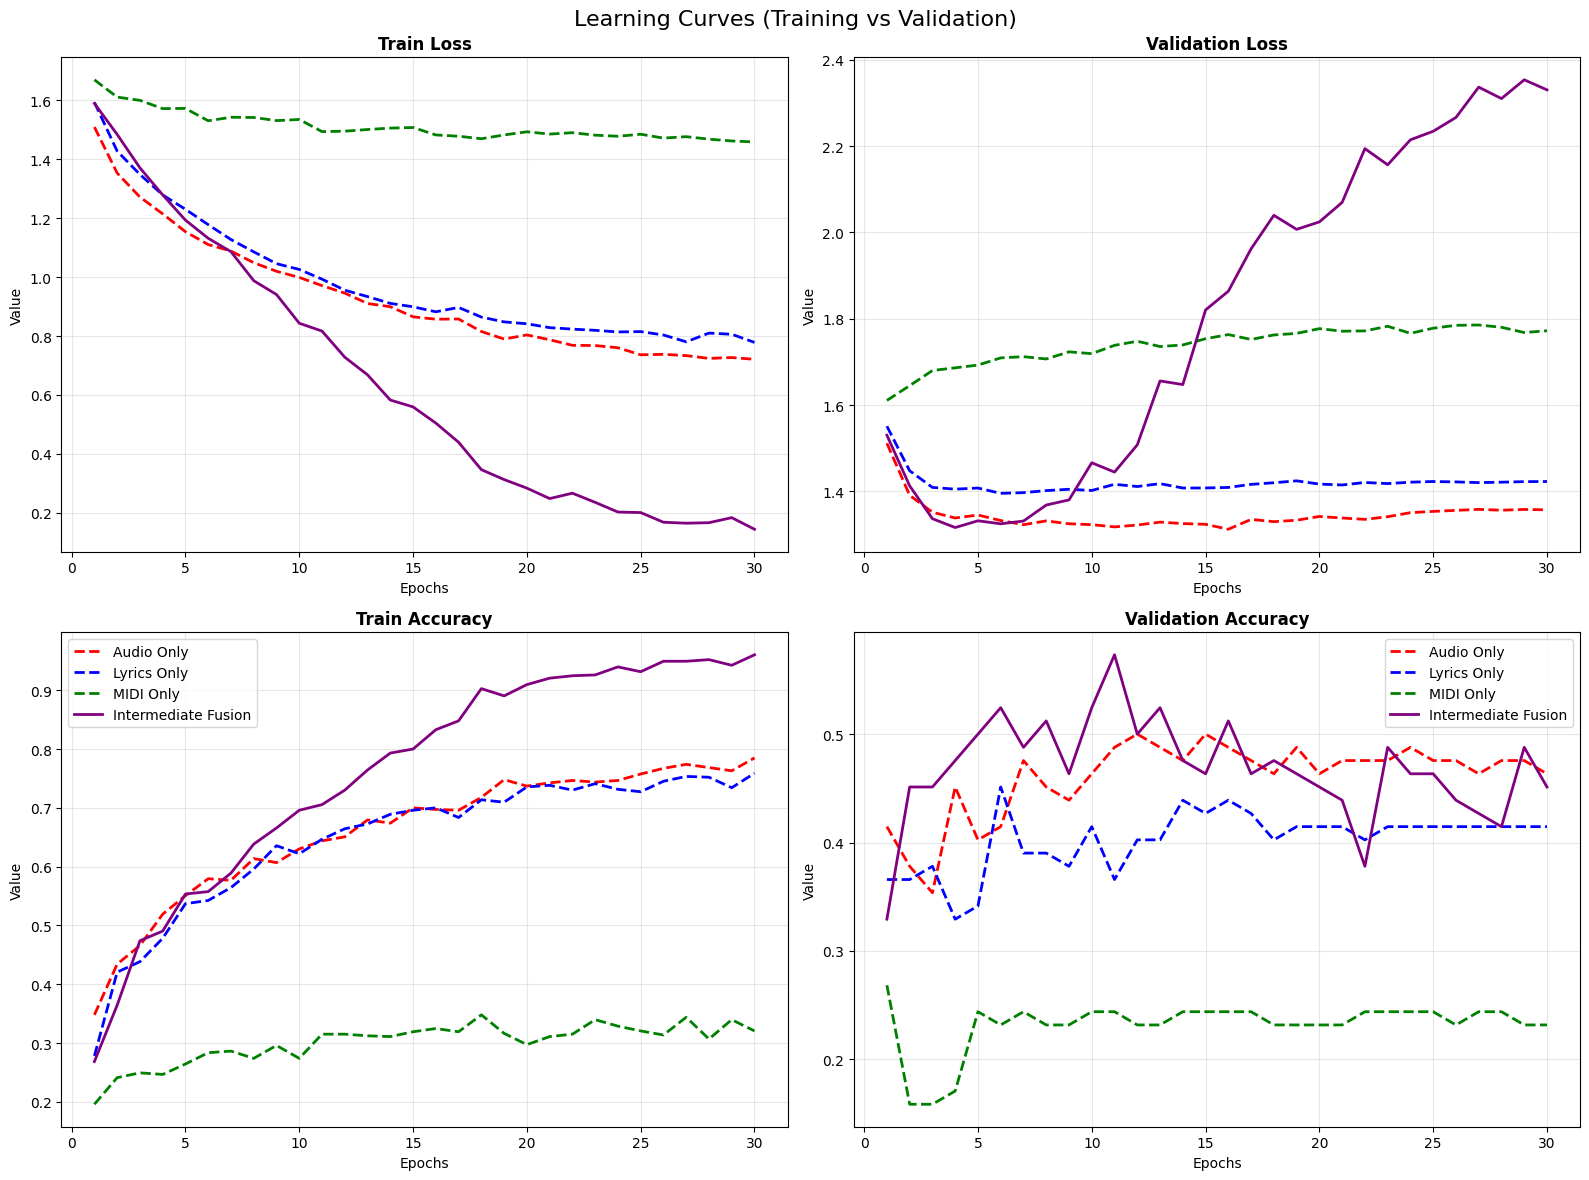

In [11]:
def plot_learning_curves(history_dict):
    epochs = range(1, EPOCHS + 1)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    titles = ["Train Loss", "Validation Loss", "Train Accuracy", "Validation Accuracy"]
    keys = ["train_loss", "val_loss", "train_acc", "val_acc"]
    colors = {"Audio Only": "red", "Lyrics Only": "blue", "MIDI Only": "green", "Intermediate Fusion": "purple"}
    styles = {"Audio Only": "--", "Lyrics Only": "--", "MIDI Only": "--", "Intermediate Fusion": "-"} 
    
    for ax, key, title in zip(axes.flatten(), keys, titles):
        for exp_name, metrics in history_dict.items():
            ax.plot(epochs, metrics[key], label=exp_name, 
                    color=colors[exp_name], linestyle=styles[exp_name], linewidth=2)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel("Epochs"); ax.set_ylabel("Value"); ax.grid(True, alpha=0.3)
        if "acc" in key: ax.legend()

    plt.suptitle("Learning Curves (Training vs Validation)", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_learning_curves(history_storage)

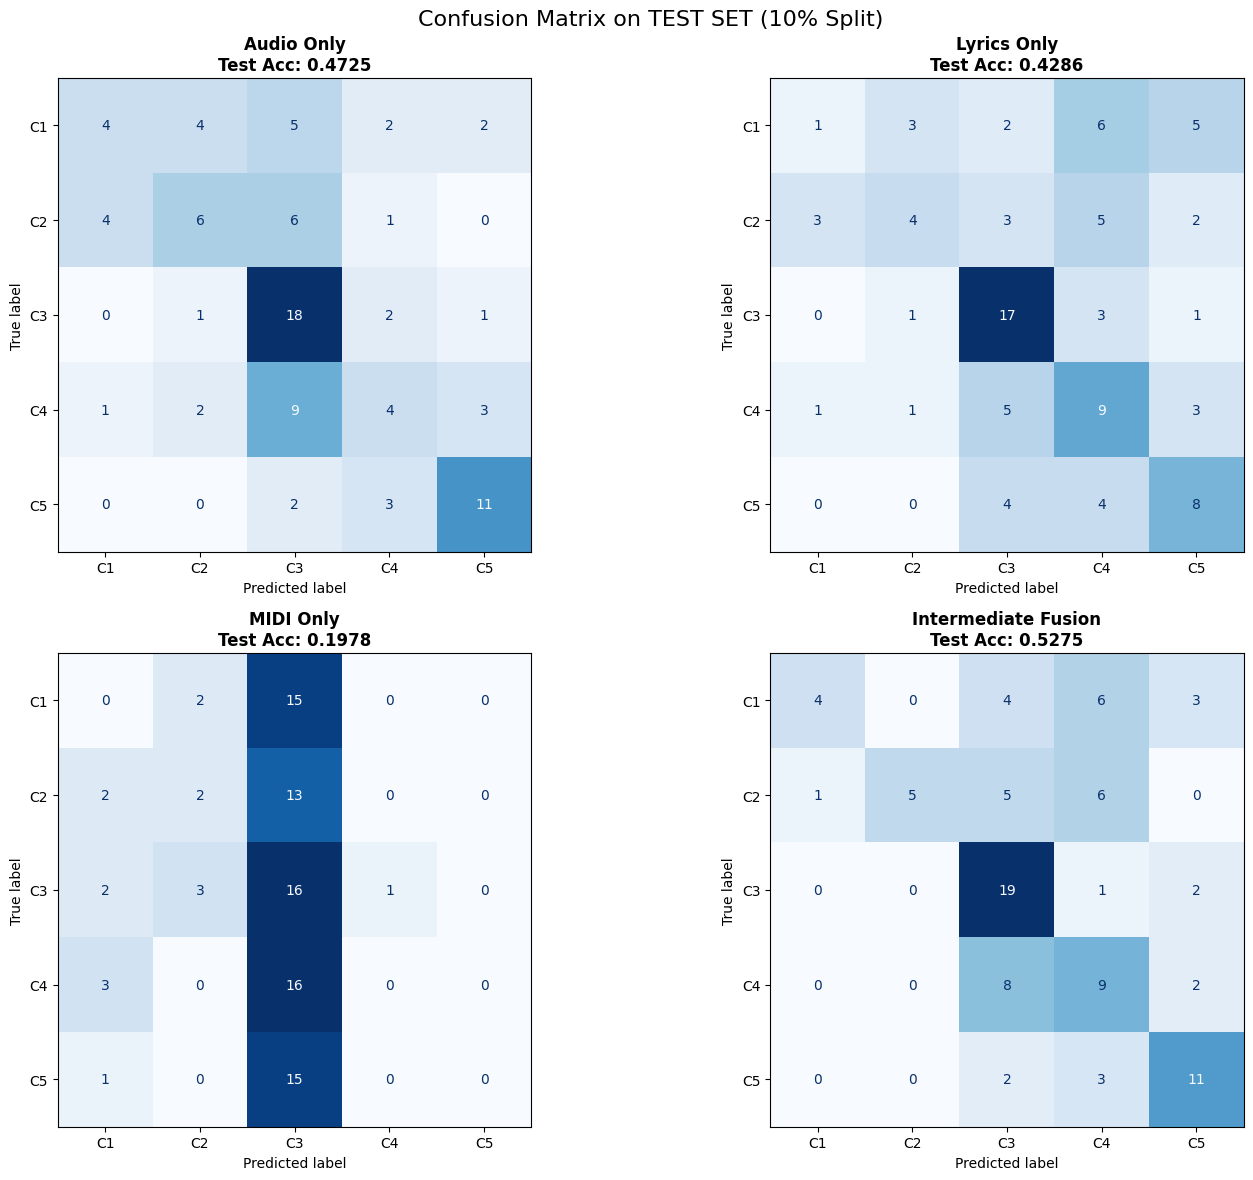


❌ INTERMEDIATE FUSION: PREDIKSI SALAH (TEST SET)


,File,True,Pred
37,873,Cluster 5,Cluster 3
24,107,Cluster 1,Cluster 3
25,214,Cluster 2,Cluster 4
36,245,Cluster 2,Cluster 1
34,103,Cluster 1,Cluster 4
39,299,Cluster 2,Cluster 3
4,122,Cluster 1,Cluster 4
12,100,Cluster 1,Cluster 4
8,481,Cluster 3,Cluster 4
3,842,Cluster 5,Cluster 4



✅ INTERMEDIATE FUSION: PREDIKSI BENAR (TEST SET)


,File,True,Pred
0,743,Cluster 5,Cluster 5
1,340,Cluster 3,Cluster 3
2,522,Cluster 3,Cluster 3
3,273,Cluster 2,Cluster 2
4,835,Cluster 5,Cluster 5


In [12]:
# 1. Plot Confusion Matrix Grid (Test Data)
def plot_all_confusion_matrices(cm_data, labels):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    order = ["Audio Only", "Lyrics Only", "MIDI Only", "Intermediate Fusion"]
    
    for i, exp_name in enumerate(order):
        ax = axes[i]
        if cm_data[exp_name]["targets"] is None: continue
        
        cm = confusion_matrix(cm_data[exp_name]["targets"], cm_data[exp_name]["preds"])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)
        
        # Tambahkan info Accuracy Test di title
        acc = accuracy_score(cm_data[exp_name]["targets"], cm_data[exp_name]["preds"])
        ax.set_title(f"{exp_name}\nTest Acc: {acc:.4f}", fontsize=12, fontweight='bold')
        ax.grid(False)

    plt.suptitle("Confusion Matrix on TEST SET (10% Split)", fontsize=16)
    plt.tight_layout()
    plt.show()

cluster_labels = [f"C{i+1}" for i in range(5)]
plot_all_confusion_matrices(confusion_matrix_data, cluster_labels)

# 2. Tampilkan Contoh Data (Test Data)
print("\n" + "="*30 + "\n❌ INTERMEDIATE FUSION: PREDIKSI SALAH (TEST SET)\n" + "="*30)
df_inc = pd.DataFrame(final_analysis_data["incorrect"])
if not df_inc.empty: display(df_inc.sample(min(10, len(df_inc)), random_state=42))

print("\n" + "="*30 + "\n✅ INTERMEDIATE FUSION: PREDIKSI BENAR (TEST SET)\n" + "="*30)
df_cor = pd.DataFrame(final_analysis_data["correct"])
if not df_cor.empty: display(df_cor)

In [13]:
from sklearn.metrics import classification_report

print("\n" + "="*50)
print("📊 DETAILED PERFORMANCE METRICS (TEST SET)")
print("="*50)

# Gunakan data prediksi yang sudah disimpan di dictionary 'confusion_matrix_data'
# Urutan eksperimen sesuai loop sebelumnya
order = ["Audio Only", "Lyrics Only", "MIDI Only", "Intermediate Fusion"]

for exp_name in order:
    # Ambil data prediksi dan target asli dari dictionary
    y_pred = confusion_matrix_data[exp_name]["preds"]
    y_true = confusion_matrix_data[exp_name]["targets"]
    
    # Cek jika data ada
    if len(y_pred) > 0:
        print(f"\n🔹 MODEL: {exp_name.upper()}")
        print("-" * 60)
        
        # Tampilkan Report
        # target_names disesuaikan dengan nama cluster (Cluster 1, Cluster 2, dst)
        print(classification_report(
            y_true, 
            y_pred, 
            target_names=[f"Cluster {i+1}" for i in range(5)],
            digits=4  # Menampilkan 4 angka di belakang koma
        ))
        print("-" * 60)


📊 DETAILED PERFORMANCE METRICS (TEST SET)

🔹 MODEL: AUDIO ONLY
------------------------------------------------------------
              precision    recall  f1-score   support

   Cluster 1     0.4444    0.2353    0.3077        17
   Cluster 2     0.4615    0.3529    0.4000        17
   Cluster 3     0.4500    0.8182    0.5806        22
   Cluster 4     0.3333    0.2105    0.2581        19
   Cluster 5     0.6471    0.6875    0.6667        16

    accuracy                         0.4725        91
   macro avg     0.4673    0.4609    0.4426        91
weighted avg     0.4614    0.4725    0.4437        91

------------------------------------------------------------

🔹 MODEL: LYRICS ONLY
------------------------------------------------------------
              precision    recall  f1-score   support

   Cluster 1     0.2000    0.0588    0.0909        17
   Cluster 2     0.4444    0.2353    0.3077        17
   Cluster 3     0.5484    0.7727    0.6415        22
   Cluster 4     0.3333  